# CMPE257 Project1: E-mail Autocomplete Project

#### Yuhua He - Data preparation, preprocessing(tf-idf), K-means algorithm, Elbow method
#### Yuanzhe Li - Finding business model, preprocessing(stemming), Testing
#### Samuel Yang - Data prepraration, Documentation, preprocessing(feature extraction), Testing

### What story is the data telling us?

#### In this group assignment, the business objective we are focusing on, is the "Smart Email Compose" project. We are using the Enron email dataset, which has the "file" column and "message" column, after servel feature extracting process, we can extract more features like "file name", "message body", from", "to", "message id". So, the data is basically show what we need. It provides several thousands of messages body with completely different structure. For example, some of the messages greeting messgae that comes up with the "hello" word frequently, and some don't. In order to recognize it, we try to apply the tf-tdf technique to find out the frequency of each words. 

### What business problem can be solved using the data?

#### From what we do and trying to processing the data, "Content Discovery" can be solved easily. After we appliedK-means cluserting algorithm, we can divided all the data into several clusters where has similar words. More importantly, by applying machine-learning algorithm, we can further categorized emails into 4 major groups, which is am essential observation for our project. We also apply the eblow method to interprete and validate the consistency within cluster analysis designed to find appropriate amount of clusters we need in this situation.

In [1]:
#import Library

import email, re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import  LatentDirichletAllocation
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

d:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Strong initial dataset (Enron Email Dataset):

In [2]:
# Read the data into a DataFrame
emails_enrich_df = pd.read_csv('rdany_conversations_2016-03-01.csv')
emails_df = pd.read_csv('D:\FreeDownloads\enron-email-dataset\emails.csv',nrows = 30000, error_bad_lines = False)
print(emails_enrich_df.shape, emails_df.shape)

(6325, 5) (30000, 2)


## Data Enrichment (Coversation Dataset):

In [3]:
emails_enrich_df.head()

,source,text,date,hashed_message_id,hashed_chat_id
0,human,[START],0,fce1649c457fcd02600f0f1aece46c1a88d3258fdfc2d8...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
1,robot,"Hi there, how are you!? 😁😁",23789,8601139615d43330986f3f27b78bcf0212d2a4f1e4a4d7...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
2,human,"Oh, thanks! I'm fine. This is an evening in my...",41177,a2eb7031aa536c89231517fc71ea3315c89ca50fef155b...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
3,robot,😄 here is afternoon!,41598,e0ac851c9ff34cd39a7e490fb9021163b8be6df097737f...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
4,human,How do you feel today? Tell me something about...,41629,0d2937ef1d5e806d46b78f2264bee44f9cbad0d68e4ce2...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...


In [4]:
#Helper functions

def get_email_text(email):
    '''To get the content from email objects'''
    email_contents = []
    for email_object in email.walk():
        if email_object.get_content_type() == 'text/plain':
            email_contents.append(email_object.get_payload())
    return ''.join(email_contents)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

## Preprocessing:

In [5]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

# Parse content from emails
emails_df['content'] = list(map(get_email_text, messages))

#rename
emails_enrich_df = emails_enrich_df.rename(index = str, columns = {"text" : "content"})

enriched_df = emails_df['content'].append(emails_enrich_df['content'], ignore_index = True).copy()

#emails_df['content'].to_csv('content.csv', index = False, header = True)
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
print(emails_df.shape)
emails_df.head()

(30000, 12)


,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
Message-ID,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s..."
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.


In [6]:
print(enriched_df.size)
enriched_df.head()
enriched_df=enriched_df.to_frame()

36325


In [7]:
#Helper function - Removing stop words, removel unimpotant words.

def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(('http', 'www', 'com' ))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    dash_pat = re.compile("--+.+--+", flags = re.DOTALL)
    star_pat = re.compile('\*\*+.+\*\*+', flags = re.DOTALL)
    uscore_pat = re.compile(" __+.+__+", flags = re.DOTALL)
    equals_pat = re.compile("==+.+==+", flags = re.DOTALL)
    to_pat = re.compile(r'^To:.*\n?',flags = re.MULTILINE)
    cc_pat = re.compile(r'^cc:.*\n?',flags = re.MULTILINE)
    subject_pat = re.compile(r'^Subject:.*\n?', flags = re.MULTILINE)
    nochar_pat = re.compile(r'[^a-zA-Z]')
    shortkiller = re.compile('\b\w{1,3}\b')
    text = text.rstrip()
    text = dash_pat.sub(' ', text)
    text = star_pat.sub(' ', text)
    text = uscore_pat.sub(' ', text)
    text = to_pat.sub('', text)
    text = cc_pat.sub('', text)
    text = subject_pat.sub('', text)
    text = equals_pat.sub(' ', text)
    text = nochar_pat.sub(' ', text)
    text = shortkiller.sub(' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    #punc_free = ' '.join(ch for ch in stop_free.split() if ch not in exclude)
    shortkill = ' '.join(ch for ch in stop_free.split() if len(ch) > 2)
    normalized = " ".join(lemma.lemmatize(word, pos='v') for word in shortkill.split())
    
    return normalized

In [8]:
enriched_df.reindex()
enriched_df.head()

,content
0,Here is our forecast\n\n
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy,\n\n Can you send me a schedule of the s..."
4,Let's shoot for Tuesday at 11:45.


In [9]:
#enriched_df[enriched_df.index.duplicated()]
#enriched_df = pd.DataFrame({"index": enriched_df.index, "content" : enriched_df.values})
type(enriched_df)

pandas.core.frame.DataFrame

In [10]:
#Drop rows have too less words
enriched_df = enriched_df[enriched_df['content'].apply(lambda x: len(x.split()) > 10)]
print("After drop:", enriched_df.shape)

After drop: (28945, 1)


## Bag of Words Model

### BoW is a really useful model for the data-preparation process especially for text data. 

In [11]:
#cleaning all numeric data
enriched_df = enriched_df.replace('\d+', 'NUM', regex=True)

#initialize the Vectorizer
count_vec = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")

# learn the vocab and parse them as features based on the given params.
count_occurs = count_vec.fit_transform(enriched_df['content'].apply(clean))

# printing first hundred features
print(count_vec.get_feature_names()[:100])

['able', 'accept', 'access', 'accord', 'account', 'across', 'act', 'action', 'active', 'activities', 'activity', 'actually', 'add', 'addition', 'additional', 'address', 'advance', 'advise', 'afternoon', 'agent', 'ago', 'agree', 'agreement', 'air', 'align', 'allen', 'allow', 'along', 'already', 'also', 'although', 'always', 'america', 'american', 'amount', 'analysis', 'analyst', 'analysts', 'anderson', 'andy', 'announce', 'another', 'answer', 'anum', 'anyone', 'anything', 'aol', 'appear', 'application', 'applications', 'apply', 'appreciate', 'appropriate', 'approval', 'approve', 'april', 'area', 'areas', 'arial', 'arnold', 'around', 'article', 'ask', 'asp', 'assets', 'assistant', 'associate', 'assume', 'attach', 'attempt', 'attend', 'audit', 'august', 'austin', 'available', 'average', 'away', 'back', 'bad', 'balance', 'ball', 'bank', 'barry', 'base', 'basis', 'bass', 'baughman', 'beck', 'become', 'begin', 'believe', 'benefit', 'best', 'beth', 'better', 'bgcolor', 'bid', 'big', 'bigplane

In [12]:
count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))

count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
print(count_occur_df.head(10))

             Word  Count
547          meet      5
121      business      4
988         would      3
883          take      3
930          trip      3
405          hold      2
931           try      2
303          even      2
695  presentation      1
882         table      1


## Linear Regression (with BoW model):

#### In order to perform linear regression model, besides combining with BoW, we also need to use LabelEncoder to convert string to numeric data

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
X = le.fit(count_occur_df['Word']).transform(count_occur_df['Word'])
y = count_occur_df['Count']
print(X.shape)
print(y.shape)

(1000,)
(1000,)


In [14]:
#Data Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

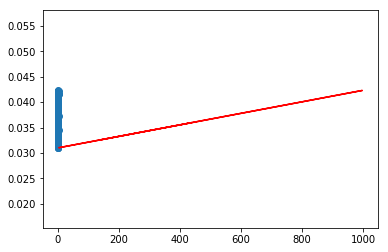

In [15]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train[:, None],y_train)

predictions = lm.predict(X_test[:, None])
plt.scatter(y_test,predictions)

plt.plot(X_test, predictions,color='red')
plt.show()

#### From the graph above we can see the words basically will all be like the "here", "is", "our", etc. Those words comes out frequently as a comparison to other words, so it will be useful for us to making a predictions that those words will more likely to appear after several patterns.

## Decision Tree:

In [16]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [17]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train[:, None],y_train)
y_pred = dt.predict(X_test[:, None])

### Evaluating the Decision Tree model:

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9225


#### The this model gives us a 92.75% accuracy, which is a really high accuracy. But, there's a chance of being "overfitting" since we only use the Hold-out Validation. To furthermore test the model's performance, we should use Cross-Validation just in case.

### Cross-Validation (for Decision Tree Model):

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, X[:,None], y, cv=10)
print("CV scores mean: {}".format(scores.mean()))

CV scores mean: 0.5624747218234614


d:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


#### From the mean of the CV scores above, we can conclude that the model is overfitting. To prevent overfitting in the Decision Tree Model, "Pruning" is a really good way to start with.

### Pruning (Prevent Overfitting for Decision Tree Model):

In [20]:
dt_after_pruning = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

In [21]:
dt_after_pruning = dt_after_pruning.fit(X_train[:, None],y_train)
y_pred2 = dt_after_pruning.predict(X_test[:, None])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.9475


#### The accuracy seems pretty high, lets futhremore move on to the Cross-Validaion. 

In [22]:
scores = cross_val_score(dt_after_pruning, X[:,None], y, cv=10)
print("CV scores mean: {}".format(scores.mean()))

CV scores mean: 0.9632426746922546


d:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


#### After pruning, the mean of CV-scores comes to 0.96 which is really high and it also shows that the Decision Tree model is really accurate in this case. As it is really useful for us to classify the text data into categories based on the word counts. 

In [23]:
#Data cleaning, removing stop words

analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
analysis_df["clean_content"]=analysis_df.content.apply(clean)
#analysis_df["clean_content"].to_csv('clean_c.csv', index = False, header = True)
analysis_df.head()

,From,To,Date,content,clean_content
Message-ID,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,(phillip.allen@enron.com),(tim.belden@enron.com),2001-05-14 16:39:00-07:00,Here is our forecast\n\n,forecast
<15464986.1075855378456.JavaMail.evans@thyme>,(phillip.allen@enron.com),(john.lavorato@enron.com),2001-05-04 13:51:00-07:00,Traveling to have a business meeting takes the...,travel business meet take fun trip especially ...
<24216240.1075855687451.JavaMail.evans@thyme>,(phillip.allen@enron.com),(leah.arsdall@enron.com),2000-10-18 03:00:00-07:00,test successful. way to go!!!,test successful way
<13505866.1075863688222.JavaMail.evans@thyme>,(phillip.allen@enron.com),(randall.gay@enron.com),2000-10-23 06:13:00-07:00,"Randy,\n\n Can you send me a schedule of the s...",randy send schedule salary level everyone sche...
<30922949.1075863688243.JavaMail.evans@thyme>,(phillip.allen@enron.com),(greg.piper@enron.com),2000-08-31 05:07:00-07:00,Let's shoot for Tuesday at 11:45.,let shoot tuesday


## Comparing Data Before And After Preprocessing:

### Original Data:

In [24]:
content_simple = emails_df.content[9]
print(content_simple)

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000 
01:42 PM ---------------------------


"Buckner, Buck" <buck.buckner@honeywell.com> on 10/12/2000 01:12:21 PM
To: "'Pallen@Enron.com'" <Pallen@Enron.com>
cc:  
Subject: FW: fixed forward or other Collar floor gas price terms


Phillip,

> As discussed  during our phone conversation, In a Parallon 75 microturbine
> power generation deal for a national accounts customer, I am developing a
> proposal to sell power to customer at fixed or collar/floor price. To do
> so I need a corresponding term gas price for same. Microturbine is an
> onsite generation product developed by Honeywell to generate electricity
> on customer site (degen). using natural gas. In doing so,  I need your
> best fixed price forward gas price deal for 1, 3, 5, 7 and 10 years for
> annual/seasonal supply to microturbines to generate fixed kWh for
> customer. We have the opportunity to sell customer kWh 's using
> microturbine or sell them turb

### Data After Preprocessing:

In [25]:
print(clean(emails_df.content[9]))

buckner buck buck buckner honeywell phillip discuss phone conversation parallon microturbine power generation deal national account customer develop proposal sell power customer fix collar floor price need correspond term gas price microturbine onsite generation product develop honeywell generate electricity customer site degen use natural gas need best fix price forward gas price deal years annual seasonal supply microturbines generate fix kwh customer opportunity sell customer kwh use microturbine sell turbines kwh deal must limit risk forward gas price make deal work therein come sempra energy gas trade truly propose instal units across large number store san diego store number vary installation hurdle face small percent hours day microturbine run time gas requirement microturbines mmcf per year gas requirement microturbines mmcf per year gas likely consume may september peak electric period gas price require burnertip price behind ldc san diego gas electric need detail breakout com

In [26]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

## Elbow Method:

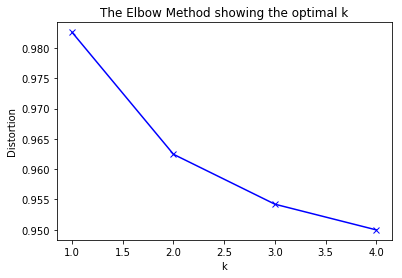

In [27]:
# make elbow plot, find k
distortions = []
k_list = range(1, 5)
for N in k_list:
    clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=10)
    labels = clf.fit_predict(wordvector_fit)
    wordvector_fit_2d = wordvector_fit.todense()
    distortions.append(sum(np.min(cdist(wordvector_fit_2d, clf.cluster_centers_, 'euclidean'), axis=1)) / wordvector_fit_2d.shape[0])

# Plot the elbow
plt.plot(k_list, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## K-Means Clustering Algorithm:

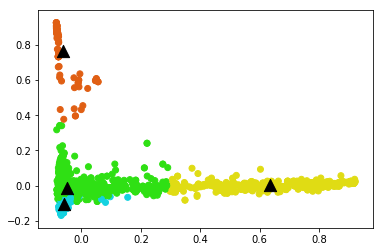

In [28]:

N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=10)
labels = clf.fit_predict(wordvector_fit)

wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

## Latent Dirichlet Allocation:

#### LDA is useful here for us to find latent manifolds in text data. 
#### Here, we try to categorize all the data in to 10 topics, by choosing specific words and classifying them by comparing the difference between the weighs of those specific words. From the scores showing below, there are ten topics. 

In [29]:
#New LDA
text_clean=[]
for text in short_analysis['clean_content']:
    text_clean.append(text.split())
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=10, id2word = dictionary, passes=30)
topics = ldamodel.print_topics(num_topics=10, num_words=10)
for i, j in enumerate(topics):
    print("Topic: {}\n{}\n".format(i, j))

Topic: 0
(0, '0.016*"get" + 0.012*"game" + 0.012*"bass" + 0.011*"know" + 0.009*"eric" + 0.008*"go" + 0.008*"like" + 0.008*"let" + 0.007*"think" + 0.007*"make"')

Topic: 1
(1, '0.013*"gas" + 0.011*"energy" + 0.011*"market" + 0.011*"trade" + 0.007*"deal" + 0.007*"power" + 0.006*"cost" + 0.006*"would" + 0.005*"contract" + 0.005*"research"')

Topic: 2
(2, '0.046*"image" + 0.010*"new" + 0.008*"risk" + 0.008*"enron" + 0.007*"management" + 0.006*"news" + 0.006*"free" + 0.006*"sally" + 0.006*"operations" + 0.006*"report"')

Topic: 3
(3, '0.037*"enron" + 0.011*"thank" + 0.011*"meet" + 0.010*"please" + 0.009*"request" + 0.009*"sally" + 0.007*"work" + 0.007*"would" + 0.006*"report" + 0.006*"business"')

Topic: 4
(4, '0.056*"font" + 0.030*"class" + 0.023*"fantasy" + 0.020*"football" + 0.019*"sportsline" + 0.018*"league" + 0.018*"players" + 0.016*"size" + 0.016*"owner" + 0.014*"random"')

Topic: 5
(5, '0.106*"font" + 0.046*"size" + 0.045*"align" + 0.027*"right" + 0.023*"width" + 0.021*"net" + 0.021

#### Obtaining these latent manifold is definitely a tool for us to improve our data mining becasue we can know how we will categorize the data, cleaning the data, and further more make predictions. By picking right topics here, our data can even be reduced so we can have better time complexity running the model.

## Gaussian Mixed Model (GMM):

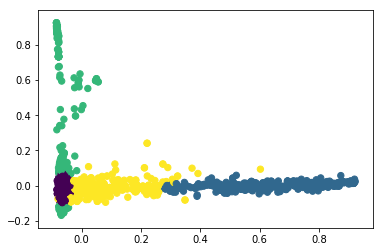

In [30]:

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(datapoint)
labels = gmm.predict(datapoint)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels, s=40, cmap='viridis');

## Sentiment Analysis

In [31]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer
from textblob.sentiments import NaiveBayesAnalyzer

In [32]:
def calculate_subjectivity (text):
# uses TextBlob to calculate subjectivity 
    testimonial = TextBlob(text)
    return testimonial.sentiment.subjectivity 

def calculate_polarity(text):
# uses TextBlob to calculate polarity """
    testimonial = TextBlob(text)
    return testimonial.sentiment.polarity

def calculate_sentiment_nb(text, attribute):
# uses this TextBlob to calculate possibility of positive and negative 
    blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    return blob.sentiment[attribute]

In [33]:
sentiment_df = analysis_df[['Date','clean_content']].dropna().copy()
print(sentiment_df.shape)
sentiment_df.head()

(21436, 2)


,Date,clean_content
Message-ID,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,forecast
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,travel business meet take fun trip especially ...
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,test successful way
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,randy send schedule salary level everyone sche...
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,let shoot tuesday


In [34]:
sentiment_df['subjectivity'] = sentiment_df.clean_content.apply(lambda x: calculate_subjectivity(x))
sentiment_df['polarity'] = sentiment_df.clean_content.apply(lambda x: calculate_polarity(x))
#takes too long time to compute, may for feed into further maching learning model
#sentiment_df['sentiment'] = sentiment_df.clean_content.apply(lambda x: calculate_sentiment_nb(x, attribute=0))
#sentiment_df['p_pos'] = sentiment_df.clean_content.apply(lambda x: calculate_sentiment_nb(x, attribute=1))
#sentiment_df['p_neg'] = sentiment_df.clean_content.apply(lambda x: calculate_sentiment_nb(x, attribute=2))

In [35]:
print(sentiment_df.shape)
sentiment_df.head()

(21436, 4)


,Date,clean_content,subjectivity,polarity
Message-ID,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,forecast,0.000000,0.000000
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,travel business meet take fun trip especially ...,0.639394,0.209091
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,test successful way,0.950000,0.750000
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,randy send schedule salary level everyone sche...,0.000000,0.000000
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,let shoot tuesday,0.000000,0.000000


In [36]:
# keep only subjective content
def subject_screen (obj):
    if obj == 0 or obj < 0:
        return 0
# screening time line
def year_dec (time):
    if time.year < 1998 or time.year > 2002:
        return 0

In [37]:
sentiment_df = sentiment_df[sentiment_df['subjectivity'].map(subject_screen) != 0]
print(sentiment_df.shape)
sentiment_df.head()

(17171, 4)


,Date,clean_content,subjectivity,polarity
Message-ID,,,,
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,travel business meet take fun trip especially ...,0.639394,0.209091
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,test successful way,0.950000,0.750000
<20641191.1075855687472.JavaMail.evans@thyme>,2000-10-17 02:26:00-07:00,login pallen davis think require isp static ad...,0.900000,0.500000
<30795301.1075855687494.JavaMail.evans@thyme>,2000-10-16 06:44:00-07:00,buckner buck buck buckner honeywell phillip di...,0.402857,0.066429
<33076797.1075855687515.JavaMail.evans@thyme>,2000-10-16 06:42:00-07:00,buckner deliver gas behind san diego enron ene...,0.600000,0.050000


In [38]:
sentiment_df1 = sentiment_df[sentiment_df['Date'].map(year_dec) != 0]
print(sentiment_df1.describe())
sentiment_df1['Date'] = pd.to_datetime(sentiment_df1['Date'], utc='us')
sentiment_df1 = sentiment_df1.set_index('Date')
print(sentiment_df1.shape)
sentiment_df1.head()

       subjectivity      polarity
count  17150.000000  17150.000000
mean       0.451749      0.119275
std        0.171952      0.208046
min        0.017857     -1.000000
25%        0.348030      0.000000
50%        0.449100      0.108333
75%        0.538095      0.220152
max        1.000000      1.000000
(17150, 3)


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean_content,subjectivity,polarity
Date,,,
2001-05-04 20:51:00+00:00,travel business meet take fun trip especially ...,0.639394,0.209091
2000-10-18 10:00:00+00:00,test successful way,0.950000,0.750000
2000-10-17 09:26:00+00:00,login pallen davis think require isp static ad...,0.900000,0.500000
2000-10-16 13:44:00+00:00,buckner buck buck buckner honeywell phillip di...,0.402857,0.066429
2000-10-16 13:42:00+00:00,buckner deliver gas behind san diego enron ene...,0.600000,0.050000


In [40]:
sentiment_df_plot = sentiment_df1.resample('M').polarity.sum()
sentiment_df_plot.index = sentiment_df_plot.index.astype(str).str[:10]
print(sentiment_df1.shape)
sentiment_df_plot.head()

(17150, 3)


Date
1999-12-31    10.021130
2000-01-31    45.914981
2000-02-29    55.994142
2000-03-31    44.803300
2000-04-30    53.058236
Name: polarity, dtype: float64

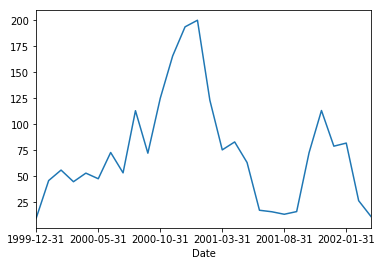

In [41]:
sentiment_df_plot.plot()